In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import tensorflow as tf
import seaborn as sns
from IPython.display import Audio, display
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Resizing, Input, Normalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.math import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
directory = '/content/drive/My Drive/'
data = pd.read_csv("/content/drive/My Drive/torgo_data/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))
data

,is_dysarthria,gender,filename
0,non_dysarthria,female,/content/drive/My Drive/torgo_data/non_dysarth...
1,non_dysarthria,female,/content/drive/My Drive/torgo_data/non_dysarth...
2,non_dysarthria,female,/content/drive/My Drive/torgo_data/non_dysarth...
3,non_dysarthria,female,/content/drive/My Drive/torgo_data/non_dysarth...
4,non_dysarthria,female,/content/drive/My Drive/torgo_data/non_dysarth...
...,...,...,...
1995,dysarthria,male,/content/drive/My Drive/torgo_data/dysarthria_...
1996,dysarthria,male,/content/drive/My Drive/torgo_data/dysarthria_...
1997,dysarthria,male,/content/drive/My Drive/torgo_data/dysarthria_...
1998,dysarthria,male,/content/drive/My Drive/torgo_data/dysarthria_...


## EDA

### Get sample audio for each class

In [4]:
data.sample(frac=1).reset_index(drop=True, inplace=True)
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_non_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_non_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
sample_data = pd.concat([male_dysarthric, female_dysarthric, male_non_dysarthric, female_non_dysarthric])
sample_data

,is_dysarthria,gender,filename
1550,dysarthria,male,/content/drive/My Drive/torgo_data/dysarthria_...
669,dysarthria,female,/content/drive/My Drive/torgo_data/dysarthria_...
1205,non_dysarthria,male,/content/drive/My Drive/torgo_data/non_dysarth...
216,non_dysarthria,female,/content/drive/My Drive/torgo_data/non_dysarth...


In [5]:
rows = 2
cols = 2
n = rows * cols

### Plot Waveform

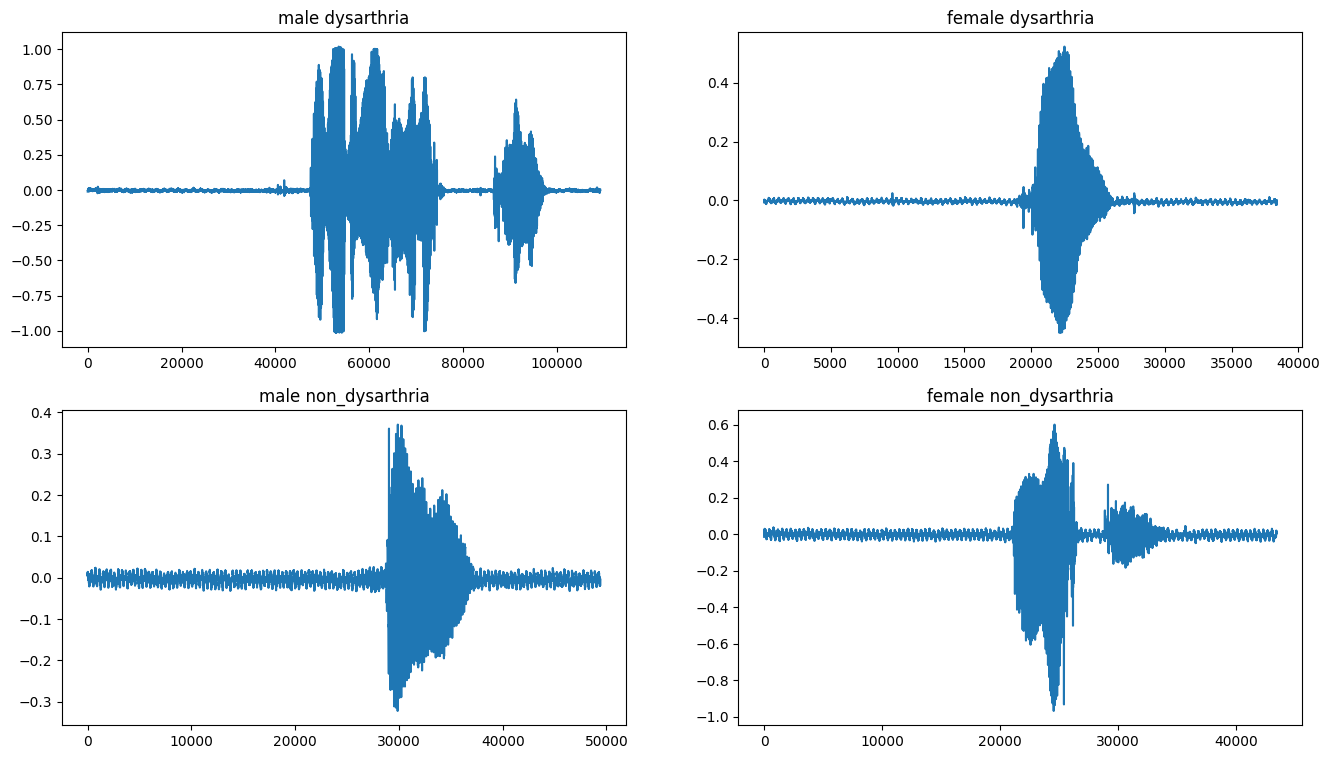

In [6]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(n):
    if i >= n: break
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    sample = sample_data.iloc[i]

    audio, sr = librosa.load(sample.filename)
    ax.plot(audio)
    ax.set_title(f'{sample.gender} {sample.is_dysarthria}')

plt.show()

### Spectrogram

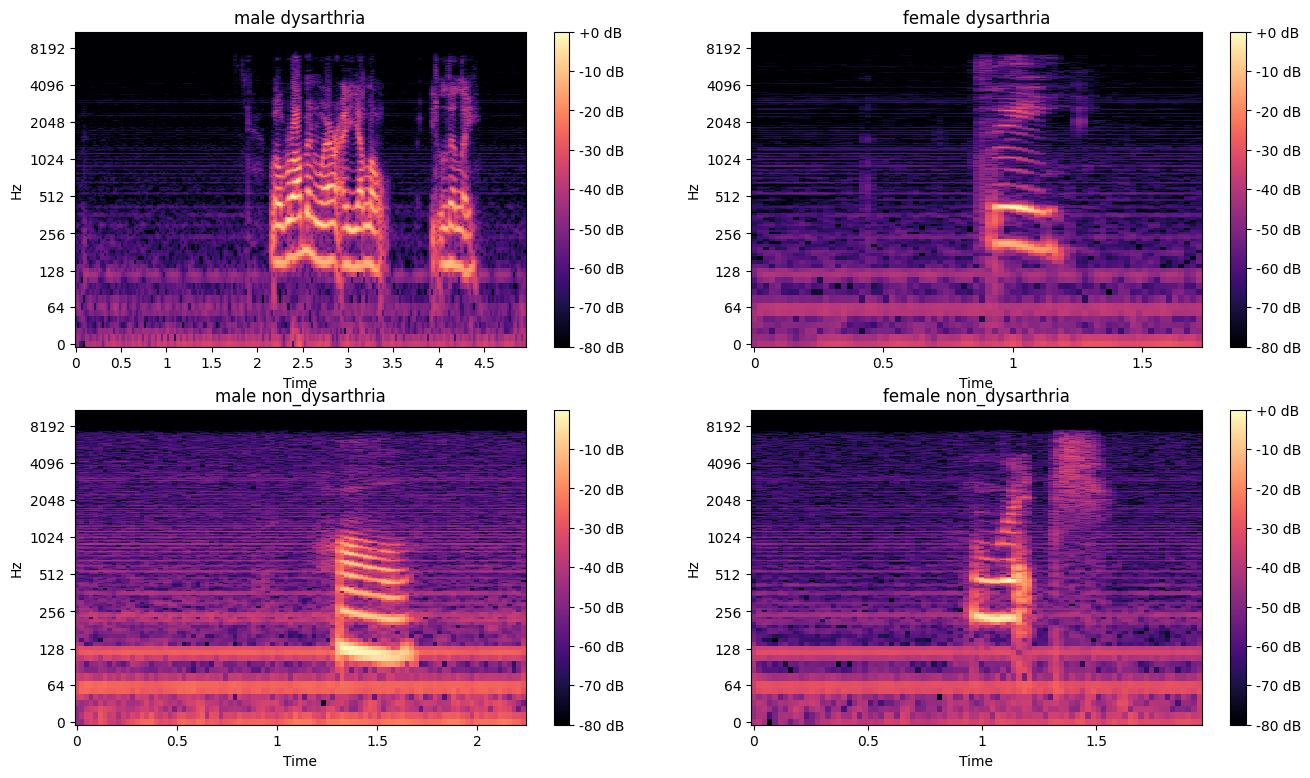

In [7]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(n):
    if i >= n: break
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    sample = sample_data.iloc[i]
    audio, sr = librosa.load(sample.filename)
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    plt.subplot(rows, cols, i + 1)
    librosa.display.specshow(spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.title(f'{sample.gender} {sample.is_dysarthria}')

plt.show()

### Mel Frequency Cepstral Coefficients (MFCC)

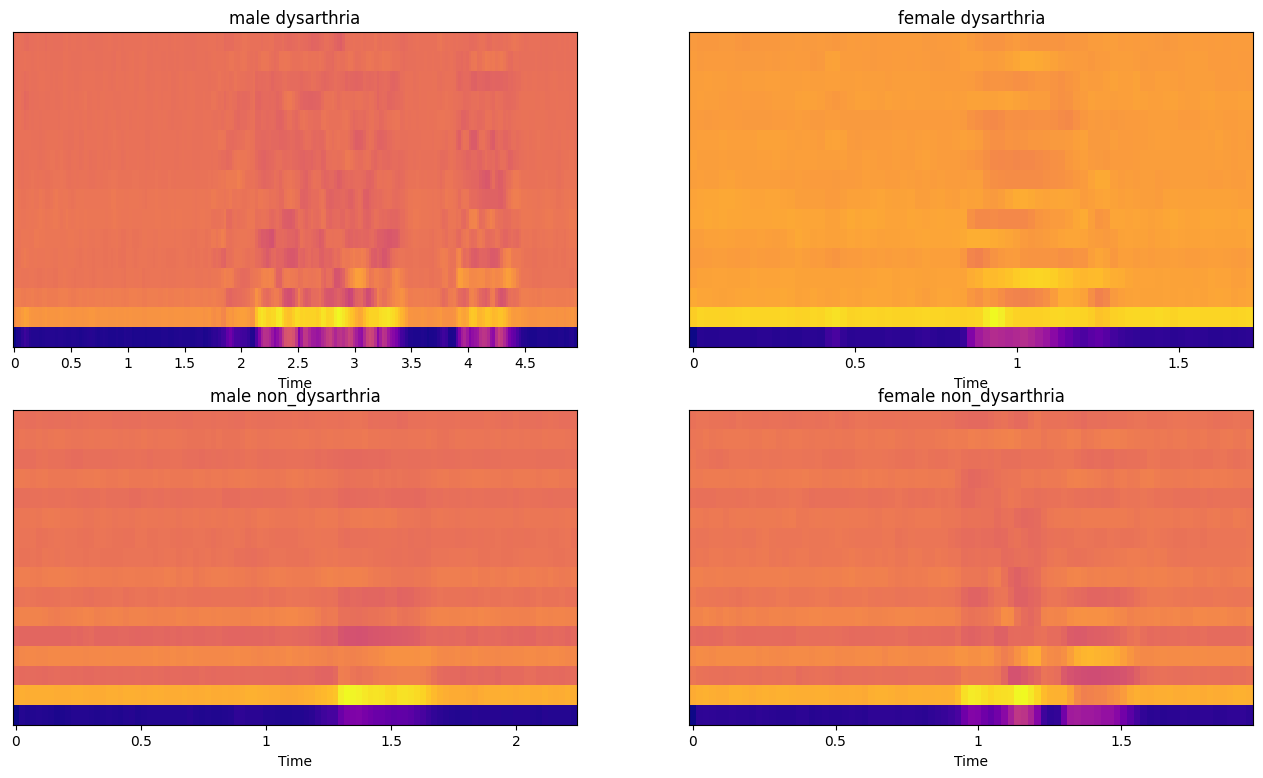

In [8]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i >= n: break
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    sample = sample_data.iloc[i]
    audio, sr = librosa.load(sample.filename)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=16, hop_length=512)
    plt.subplot(rows, cols, i + 1)
    librosa.display.specshow(mfcc, x_axis='time', cmap='plasma')
    plt.title(f'{sample.gender} {sample.is_dysarthria}')

plt.show()

### Spectral Rolloff

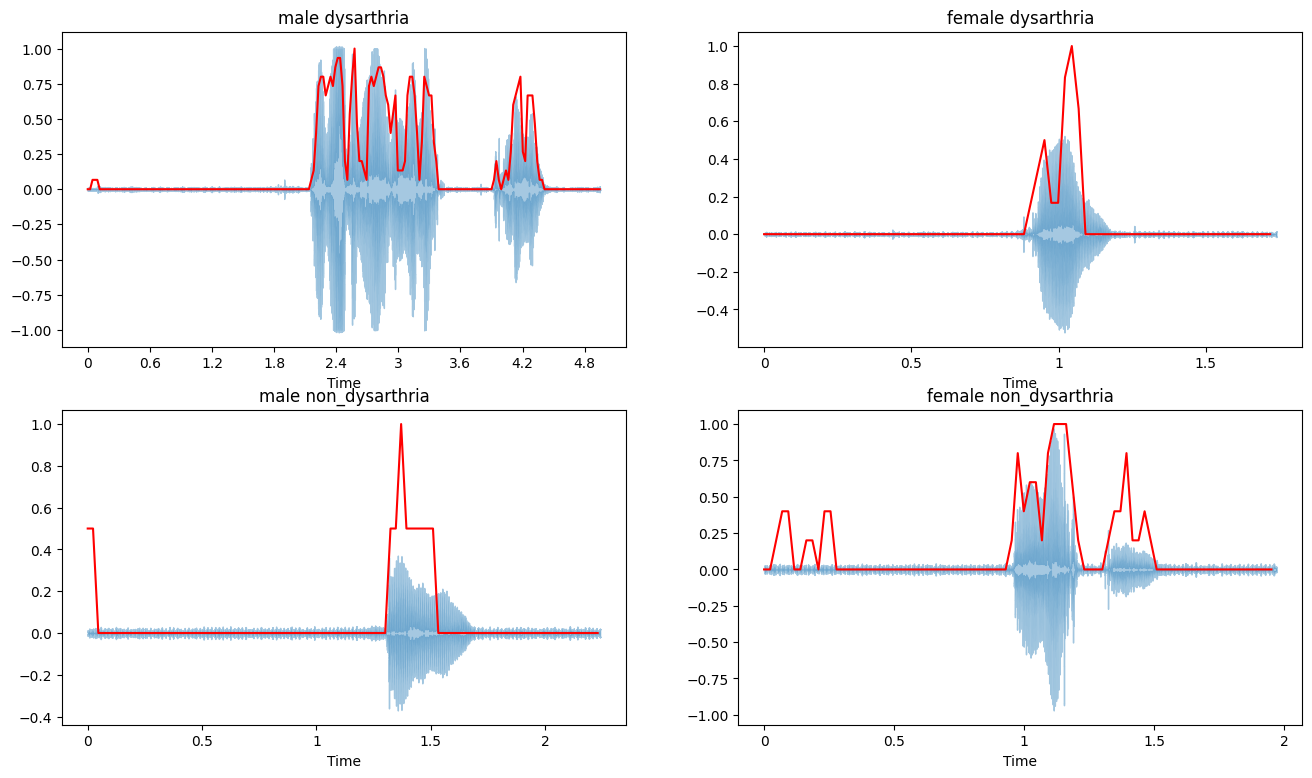

In [9]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i >= n: break
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    sample = sample_data.iloc[i]
    audio, sr = librosa.load(sample.filename)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.01)[0]
    plt.subplot(rows, cols, i + 1)
    t = librosa.frames_to_time(range(len(spectral_rolloff)))
    spectral_rolloff = minmax_scale(spectral_rolloff, axis=0)
    librosa.display.waveshow(audio, sr=sr, alpha=0.4)
    plt.plot(t, spectral_rolloff, color='r')
    plt.title(f'{sample.gender} {sample.is_dysarthria}')

plt.show()

### Zero Crossing Rate

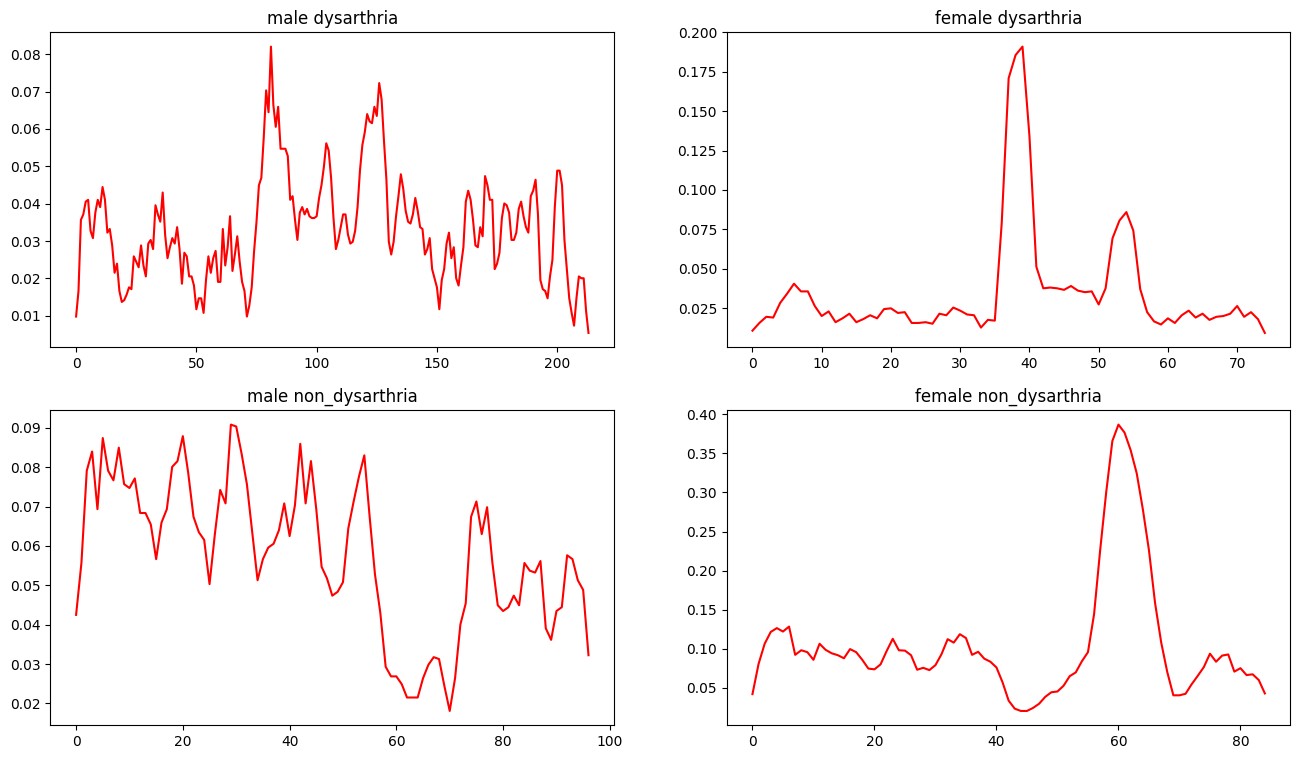

In [10]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i >= n: break
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    sample = sample_data.iloc[i]
    audio, sr = librosa.load(sample.filename)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
    plt.subplot(rows, cols, i + 1)
    plt.plot(zero_crossing_rate, color='r')
    plt.title(f'{sample.gender} {sample.is_dysarthria}')

plt.show()

## Preprocessing

### Removing broken audios

In [11]:
def check_audio(row):
    try:
        audio, sr = librosa.load(row.filename)
        return True
    except Exception as e:
        print(f"Error processing {row.filename}: {e}")
        return False

valid = data.apply(check_audio, axis=1)
data = data[valid]
data.reset_index(drop=True, inplace=True)
data.shape

<ipython-input-11-ecb48728cc09>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(row.filename)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /content/drive/My Drive/torgo_data/dysarthria_female/F01_Session1_0068.wav: 


(1999, 3)

### Extract Spectrogram (not used)

In [12]:
# def get_spectrogram(row):
#     try:
#         audio, sr = librosa.load(row.filename)
#         spectrogram = np.mean(librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max), axis=1)
#         return spectrogram
#     except Exception as e:
#         print(f"Error processing {row.filename}: {e}")
#         return [np.nan]

### Extract MFCC

In [13]:
def get_mfcc(row):
    try:
        audio, sr = librosa.load(row['filename'])
        mean_mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=128), axis=1)
        return mean_mfcc
    except Exception as e:
        print(f"Error processing {row.filename}: {e}")
        return [np.nan]

In [14]:
features = data.apply(get_mfcc, axis=1)
mfcc_data = pd.DataFrame(features.tolist(), index=data.index)
mfcc_data['is_dysarthria'] = data['is_dysarthria']
mfcc_data.head()

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=583
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=581
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=185
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=946
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=214
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,is_dysarthria
0,-221.788269,101.259232,-16.548132,38.492065,-13.595653,20.772556,-5.536349,10.410690,1.962461,-0.799048,...,0.962193,0.744855,1.058080,0.388451,0.081758,0.546172,0.594357,0.170033,-0.219215,non_dysarthria
1,-299.520081,109.872574,-17.097267,38.854969,-16.881130,22.959133,1.824228,18.724186,3.448541,4.455821,...,1.105589,1.056284,1.252576,0.027333,-1.368948,-0.037859,0.020661,-0.082124,-0.744831,non_dysarthria
2,-302.950043,112.048477,-23.679882,44.887421,-22.434727,26.299335,0.811477,18.210291,4.344697,4.912156,...,0.844332,0.530004,1.018391,0.055385,-1.472088,0.295324,0.191228,-0.224301,-0.582725,non_dysarthria
3,-210.861603,116.504486,-35.046497,37.670425,-27.112514,25.593725,-7.511986,13.140750,-0.587347,4.138087,...,0.630752,0.898457,0.721398,0.174576,-0.090706,0.001523,0.360464,-0.075449,-0.259715,non_dysarthria
4,-280.227203,104.505035,-17.209877,45.064884,-15.542122,28.115065,-3.449209,16.841436,4.573242,1.738296,...,1.596206,0.970084,0.732015,0.547593,-0.152664,0.131893,-0.288228,-0.468570,-0.461726,non_dysarthria


### Standardize MFCC with RobustScaler

In [15]:
mfcc_data["is_dysarthria"] = LabelEncoder().fit_transform(mfcc_data["is_dysarthria"])
X = mfcc_data.iloc[:,:-1].values
y = mfcc_data['is_dysarthria']

X = RobustScaler().fit_transform(X)

### Train (70%), Test (15%), Validation (15%) split

In [16]:
x_train, x_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test1, y_test1, test_size=0.5, random_state=42)

In [17]:
x_train = x_train.reshape(-1,16,8,1)
x_val = x_val.reshape(-1,16,8,1)
x_test = x_test.reshape(-1,16,8,1)

In [18]:
input_shape = x_train.shape[1:]

In [19]:
print(input_shape)

(16, 8, 1)


### Modelling

In [20]:
from tensorflow.keras.layers import InputLayer, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape

In [21]:
model_rnn = Sequential([
    InputLayer(input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Reshape((-1, 256)),
    TimeDistributed(Dense(64)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 4, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 4, 32)          18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 2, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 256)               0

In [22]:
print(x_train.shape)

(1399, 16, 8, 1)


In [23]:
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
earlyStopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 2, verbose = 1, restore_best_weights=True)

In [25]:
EPOCHS = 10
history = model_rnn.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=earlyStopping)

Epoch 1/10
44/44 [==============================] - 3s 20ms/step - loss: 0.5793 - accuracy: 0.7127 - val_loss: 0.4256 - val_accuracy: 0.7833
Epoch 2/10
44/44 [==============================] - 1s 11ms/step - loss: 0.3476 - accuracy: 0.8585 - val_loss: 0.1849 - val_accuracy: 0.9300
Epoch 3/10
44/44 [==============================] - 0s 10ms/step - loss: 0.1552 - accuracy: 0.9478 - val_loss: 0.0926 - val_accuracy: 0.9600
Epoch 4/10
44/44 [==============================] - 0s 11ms/step - loss: 0.0529 - accuracy: 0.9836 - val_loss: 0.0611 - val_accuracy: 0.9733
Epoch 5/10
44/44 [==============================] - 0s 11ms/step - loss: 0.0650 - accuracy: 0.9800 - val_loss: 0.0392 - val_accuracy: 0.9800
Epoch 6/10
44/44 [==============================] - 1s 12ms/step - loss: 0.0345 - accuracy: 0.9878 - val_loss: 0.0733 - val_accuracy: 0.9767
Epoch 7/10
44/44 [==============================] - 0s 11ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.0457 - val_accuracy: 0.9867
Epoch 7: earl

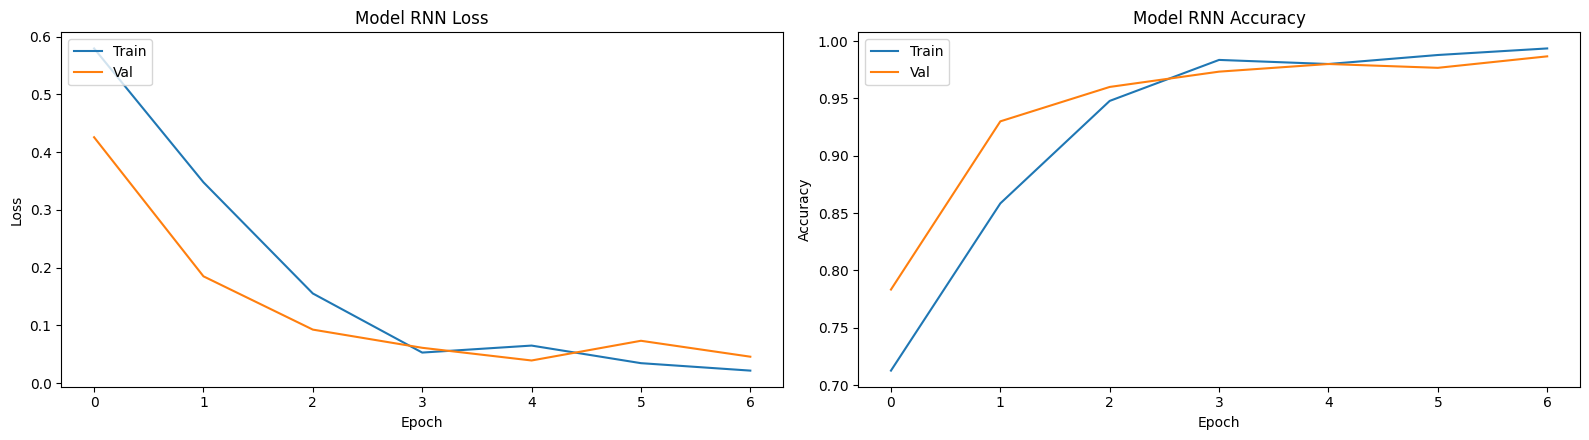

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model RNN Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Val'], loc='upper left')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model RNN Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

### Predicting Testing Set

In [27]:
y_pred = model_rnn.predict(x_test)

10/10 [==============================] - 0s 3ms/step


In [28]:
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

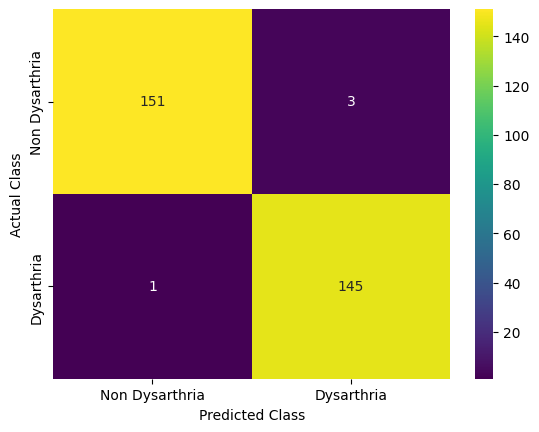

In [29]:
sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.3g',xticklabels=['Non Dysarthria','Dysarthria'],yticklabels=['Non Dysarthria','Dysarthria'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [30]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non Dysarthria', 'Dysarthria']))

Classification Report:
                precision    recall  f1-score   support

Non Dysarthria       0.99      0.98      0.99       154
    Dysarthria       0.98      0.99      0.99       146

      accuracy                           0.99       300
     macro avg       0.99      0.99      0.99       300
  weighted avg       0.99      0.99      0.99       300



## Testing on new Data

In [31]:
directory = '/content/drive/My Drive/'
test_data = pd.read_csv("/content/drive/My Drive/testing_data/data.csv")
test_data['filename'] = test_data['filename'].apply(lambda x: os.path.join(directory,x))
test_data

,is_dysarthria,filename
0,non_dysarthria,/content/drive/My Drive/testing_data/001.wav
1,dysarthria,/content/drive/My Drive/testing_data/002.wav
2,dysarthria,/content/drive/My Drive/testing_data/003.wav


### Get MFCC for the new data

In [32]:
test_features = test_data.apply(get_mfcc, axis=1)
test_mfcc = pd.DataFrame(test_features.tolist(), index=test_data.index)
test_mfcc['is_dysarthria'] = test_data['is_dysarthria']
test_mfcc["is_dysarthria"] = LabelEncoder().fit_transform(test_mfcc["is_dysarthria"])
test_mfcc.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,is_dysarthria
0,-318.893066,76.297707,-46.067299,27.522827,-29.502930,20.568413,-33.269653,9.075609,-19.336826,-0.110917,...,0.663722,-0.106383,-0.145479,-0.223831,0.990323,-0.439344,-0.501632,-0.344858,0.353536,1
1,-336.003632,57.527988,-13.724583,16.384026,-32.386097,24.186470,-17.020250,10.532653,-6.614578,1.063358,...,1.716760,0.692090,0.423385,-0.860330,1.675194,0.024876,0.087185,-0.309499,1.131088,0
2,-447.506958,145.912628,-1.650035,4.883323,8.621211,-21.212669,-7.169621,-3.348120,-12.841691,2.696569,...,0.084460,-0.269792,0.075430,0.311501,0.001142,0.178189,0.219749,0.058403,0.237552,0


In [33]:
testing_x = test_mfcc.iloc[:,:-1].values
testing_y = test_mfcc['is_dysarthria']

testing_x = RobustScaler().fit_transform(testing_x)

print(testing_x.shape, testing_y.shape)

(3, 128) (3,)


In [34]:
testing_x = testing_x.reshape(-1,16,8,1)

In [35]:
result = model_rnn.predict(testing_x)
result

1/1 [==============================] - 0s 15ms/step


array([[0.9969641 ],
       [0.03493162],
       [0.01626617]], dtype=float32)

In [36]:
result[result>=0.5] = 1
result[result<0.5] = 0

In [37]:
df_result = pd.DataFrame({'actual_class': testing_y, 'predicted_class': result.reshape(1, -1)[0], 'filename': test_data['filename']})

In [38]:
def get_label(label):
    return 'non_dysarthria' if label == 1 else 'dysarthria'

In [39]:
for index, row in df_result.iterrows():
    print(f"Actual Class: {get_label(row['actual_class'])}")
    print(f"Predicted Class: {get_label(row['predicted_class'])}")
    display(Audio(filename=row['filename']))

Actual Class: non_dysarthria
Predicted Class: non_dysarthria


Actual Class: dysarthria
Predicted Class: dysarthria


Actual Class: dysarthria
Predicted Class: dysarthria
